# Objectif

Expérimenter les différents algorithmes classiques et Machine Learning pour faire une recommandation sur le choix de l'algorithme

# Pistes de réflexion

- Tester et visualiser les prévisions de ventes pour des algorithmes :
    - Naïf ( répétition même valeur)
    - Répétition d’un cycle de vente (paramètre : nombre de jours du cycle répété)
    - Vente moyenne sur les jours similaires, même mois, même semaine, même magasin, même produit
    - Méthode par décomposition
    - Random Forest
- Comparer les résultats et interpréter
- Fournir une recommandation sur l’algorithme à choisir
- Fournir les prévisions pour trois via trois algorithmes

# Importation des modules Python et des données

In [1]:
#Importation des modules
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.base import BaseEstimator, ClassifierMixin
from model import Modeling, train_test_split_by_date, series_to_supervised, LightGBM_Modeling
from sklearn.preprocessing import LabelEncoder

sns.set_style("ticks")

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
le = LabelEncoder()

#Importation des données
data_df = pd.read_csv('././data/train_part_one.csv', parse_dates=["Date"])
data_df["Month"] = data_df["Date"].dt.month
data_df["Year"] = data_df["Date"].dt.year
data_df["Week"] = data_df["Date"].dt.week

#Importation du fichier réponse
submission_df = pd.read_csv('././data/test_part_one.csv', parse_dates=["Date"])
submission_df["Month"] = submission_df["Date"].dt.month
submission_df["Year"] = submission_df["Date"].dt.year
submission_df["Week"] = submission_df["Date"].dt.week

#Week Encoder
le.fit( pd.concat([ data_df["Date"] , submission_df["Date"] ]))
data_df["Timepoint"] = le.transform(data_df["Date"])
submission_df["Timepoint"] = le.transform(submission_df["Date"])

In [3]:
data_df.head()

Store  Item       Date  Weekly_Sales  Month  Year  Week  Timepoint
0      1     1 2010-02-05         24924      2  2010     5          0
1      1     1 2010-02-12         46039      2  2010     6          1
2      1     1 2010-02-19         41595      2  2010     7          2
3      1     1 2010-02-26         19403      2  2010     8          3
4      1     1 2010-03-05         21827      3  2010     9          4

In [4]:
submission_df.head()

Store  Item       Date  Month  Year  Week  Timepoint
0      1     1 2012-09-07      9  2012    36        135
1      1     1 2012-09-14      9  2012    37        136
2      1     1 2012-09-21      9  2012    38        137
3      1     1 2012-09-28      9  2012    39        138
4      1     2 2012-09-07      9  2012    36        135

In [5]:
X_train, X_test, y_train, y_test = train_test_split_by_date(
    data_df, target="Weekly_Sales", train_size=0.8)

In [6]:
X_train, X_test, y_train, y_test = train_test_split_by_date(
    data_df, target="Weekly_Sales", train_size=0.8)

In [7]:
X_train.head()

Store  Item       Date  Month  Year  Week  Timepoint
0         1     1 2010-02-05      2  2010     5          0
4455      5     6 2010-02-05      2  2010     5          0
3105      4     3 2010-02-05      2  2010     5          0
405       1     4 2010-02-05      2  2010     5          0
4050      5     3 2010-02-05      2  2010     5          0

In [8]:
X_test.head()

Store  Item       Date  Month  Year  Week  Timepoint
0      2     6 2012-03-02      3  2012     9        108
1      2     5 2012-03-02      3  2012     9        108
2      3     7 2012-03-02      3  2012     9        108
3      4     4 2012-03-02      3  2012     9        108
4      3     4 2012-03-02      3  2012     9        108

# Exemple 1
## Méthode : Répétition d'un cycle de valeur

### Introduction
Dans cette partie nous commençons par explorer une méthode très simpliste. Dans celle-ci nous faisons pour hypothèse que pour chaque produit et chaque magasin, les ventes suivent un cycle correspondant aux $k$ dernière valeurs connues pour les ventes de ce produit dans ce magazin

C'est à dire :

$ŷ(t,n,m) = y(t_0 - (t-t_0)/k ,n,m)$, 

- $ŷ$ la prédiction de vente
- $y$ les ventes réelles
- $t$ la date
- $n$ le numéro du produit
- $m$ le numéro du magasin
- $t_0$ la dernière valeur connue
- $k$ la longueur du cycle

In [9]:
class Duplication(BaseEstimator, ClassifierMixin):
    """
    class for duplication model
    """
    def __init__(self, week_cycle= 1, name='duplication'):
        """
        init function
        
        Parameters:
        -----------
        name: str
            Name of the model
        week_cycle : int
            Parameters of the model (week_cycle), to specify the length of the cycle k
        """

        self.name = name
        self.week_cycle = week_cycle

    def fit(self, X, y):
        """
        fit function as in scikit-learn
        
        Parameters:
        -----------
        X : pd.DataFrame
            Input dataframe
        
        y: pd.DataFrame
            Output/Target dataframe
        
        Returns:
        --------
        self: object 
        
        """
        # Check that X and y have correct shape

        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):
        """
        predict function, caculate the output given with regard to its input.
        This model takes the most recent k-values and repeat them according to 
        item and store.
        
        Parameters:
        -----------
        X : pd.DataFrame
            Input dataframe
        
        Returns:
        --------
        y : pd.Series
            predicted y values
            
        """

        # Check is fit had been called
        check_is_fitted(self)
        y = pd.Series(index=X.index)

        #loop for each Item and Store
        for item in self.X_["Item"].unique():
            for store in self.X_["Store"].unique():
                temp_train = self.X_[np.logical_and(self.X_["Item"] == item,
                                                    self.X_["Store"] == store)]
                temp_test = X[np.logical_and(X["Item"] == item,
                                             X["Store"] == store)]
                index_test = temp_test.index
                # take the top-k largest timepoint, most recent values
                temp_sales = temp_train.nlargest(self.week_cycle,
                                                 "Timepoint")

                index_train = []

                for c in temp_sales["Timepoint"].values.tolist():
                    index_train += self.X_[np.logical_and.reduce([
                        self.X_["Item"] == item, self.X_["Store"] == store,
                        self.X_["Timepoint"] == c
                    ])].index.values.tolist()

                # repeat the value until the size of index test
                rep = np.resize(index_train[::-1], len(index_test))
                # attribute values to y our predicted target
                y.at[index_test] = self.y_.loc[rep].values

        return y

## Utilisation de la classe Modeling pour évaluer le modèle

/Users/patricklee/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/patricklee/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Train score (mae) : 7000.42
Test score (mae) : 6246.01
Train score (mape) : 34.20
Test score (mape) : 29.26


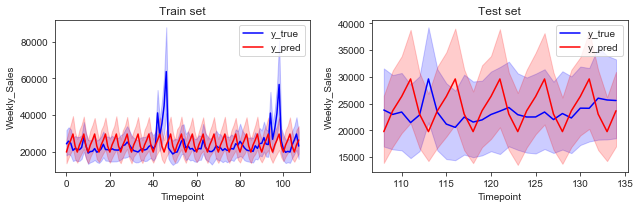

In [11]:
l_cross_validation = True

if l_cross_validation:
    model = Duplication()
    m = Modeling(model)
    cv_results = m.cv(X_train, y_train, params={"week_cycle": np.arange(1,10,2)})
    best_params = cv_results.best_params_
else:
    best_params = {'week_cycle': 9}
    
    
model = Duplication(**best_params)
m = Modeling(model)
m.fit(X_train, y_train)
y_pred = m.predict(X_test)
y_train_pred = m.predict(X_train)
eval_duplication = m.evaluation(y_train,
                                y_train_pred,
                                y_test,
                                y_pred,
                                method=["mae", "mape"],
                                verbose=True)
fig, ax = plt.subplots(1,2, figsize=(9,3))
m.prediction_visualization(X_train["Timepoint"], y_train, y_train_pred, ax=ax[0])
ax[0].set_title("Train set")
m.prediction_visualization(X_test["Timepoint"], y_test, y_pred, ax=ax[1])
ax[1].set_title("Test set")
plt.tight_layout()

In [12]:
best_params

{'week_cycle': 5}

## Enregistrement des valeurs prédites pour le test set

In [13]:
# submit predicted values
y_submit = m.predict(submission_df)
y_submit.to_csv("y_pred_model_%s.csv" %(model.name))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


# Exemple 2 
## Méthode : Moyenne sur les valeurs "similaires"

## Introduction
Dans cette méthode on fait l'hypothèse que les ventes seront la moyenne des ventes pour ce même produit dans ce même magasin les années précédentes


In [14]:
class Similarity(BaseEstimator, ClassifierMixin):
    """
    class for similarity model: aggregate by mean of previous sales for the specific store and item
    """
    def __init__(self, name='similarity', agg_func="mean"):
        """
        init function
        
        Parameters:
        -----------
        name: str
            Name of the model
        """

        self.name = name
        self.agg_func = agg_func

    def fit(self, X, y):
        """
        fit function as in scikit-learn
        
        Parameters:
        -----------
        X : pd.DataFrame
            Input dataframe
        
        y: pd.DataFrame
            Output/Target dataframe
        
        Returns:
        --------
        self: object 
        
        """
        # Check that X and y have correct shape

        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):
        """
        predict function, caculate the output given with regard to its input.
        This model takes the aggregation by agg_func according to 
        item and store.
        
        Parameters:
        -----------
        X : pd.DataFrame
            Input dataframe
        
        Returns:
        --------
        y : pd.Series
            predicted y values
            
        """

        # Check is fit had been called
        check_is_fitted(self)
        y = pd.Series(index=X.index)
        
        for index, row in X.iterrows():
            # search by month if possible, otherwise, 
            temp_df = self.X_[np.logical_and.reduce([
                self.X_["Month"] == row["Month"],
                self.X_["Store"] == row["Store"],
                self.X_["Item"] == row["Item"]
            ])]
            
            if not temp_df.index.tolist():
                temp_df = self.X_[np.logical_and(
                self.X_["Store"] == row["Store"],
                self.X_["Item"] == row["Item"]
            )]
            y.at[index] = self.y_[temp_df.index].agg(self.agg_func)
        return y

/Users/patricklee/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/patricklee/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Train score (mae) : 3149.72
Test score (mae) : 2985.00
Train score (mape) : 13.21
Test score (mape) : 14.22


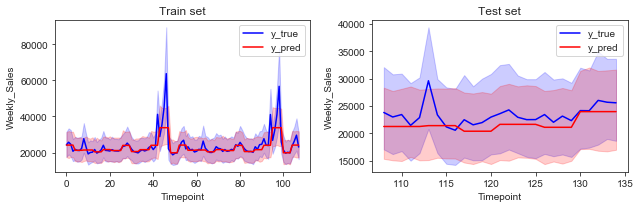

In [15]:
l_cross_validation = True

if l_cross_validation:
    model = Similarity()
    m = Modeling(model)
    cv_results = m.cv(X_train, y_train, params={"agg_func": ["mean", "median"]})
    best_params = cv_results.best_params_
else:
    best_params = {'agg_func': "median"}
    
model = Similarity(**best_params)
m = Modeling(model)
m.fit(X_train, y_train)
y_pred = m.predict(X_test)
y_train_pred = m.predict(X_train)
eval_duplication = m.evaluation(y_train,
                                y_train_pred,
                                y_test,
                                y_pred,
                                method=["mae", "mape"],
                                verbose=True)
fig, ax = plt.subplots(1,2, figsize=(9,3))
m.prediction_visualization(X_train["Timepoint"], y_train, y_train_pred, ax=ax[0])
ax[0].set_title("Train set")
m.prediction_visualization(X_test["Timepoint"], y_test, y_pred, ax=ax[1])
ax[1].set_title("Test set")
plt.tight_layout()

In [16]:
#A vous de jouer avec d'autres modèles